In [11]:
import nltk, re, pprint
from nltk import word_tokenize
import os,json
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize 
import nltk.data
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import sentiment
from nltk import word_tokenize
import augur
import sqlalchemy as s
import matplotlib.pyplot as plot
import matplotlib.dates as mdates
import pandas as pd
from scipy import stats
%matplotlib inline

## Load:
First loads the users data from 'augur.config.json' so will take the Database information (e.g. name of database, port of database). Then connects to the database using augur.App.ghtorrentplus(), loads piper_reader and loads the path to the list of mailing lists 'runtine/mailing_lists.csv'

In [2]:
if("notebooks" not in os.getcwd()):
    os.chdir("notebooks")
augurApp = augur.Application('../augur.config.json')
connect = augurApp.ghtorrentplus()

## Connect:

Gets the tables that are in the database and checks so see if 'mailing_list_jobs' is in the Database if it is it stores it in a dataframe 'df1'.

In [3]:
table_names = s.inspect(connect.db).get_table_names()
print(table_names)

if("mailing_list_jobs" in table_names):
    lists_createdSQL = s.sql.text("""SELECT project FROM mailing_list_jobs""")
    df1 = pd.read_sql(lists_createdSQL, connect.db)
    print(df1)
    val = True

['github_issues', 'github_issues_2', 'github_issues_repo_jobs', 'github_issues_sentiment_scores', 'github_pull_request_repo_jobs', 'github_pull_requests', 'github_pull_requests_2', 'github_pull_requests_sentiment_scores', 'github_pull_requests_sentiment_scores_2', 'issue_response_time', 'mail_lists', 'mail_lists_sentiment_scores', 'mailing_list_jobs']
          project
0      aalldp-dev
1      aalldp-dev
2  archetypes-dev
3  archetypes-dev


## Sentiment Scores:

Loads the SentimentIntensityAnalyzer from NLTK (Natural Language Tool Kit) and pulls all the messages from 'mail_lists' for a specific mailing lists and groups them by 'message_id'. It then goes about getting a score for the message and calculates the average score for when the sentences are broken up into smaller pieces.

In [4]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
sid = SentimentIntensityAnalyzer()
col = 'score','sentiment'
columns1 = 'augurmsgID', 'backend_name','project','mailing_list','category',\
           'message_part','message_parts_tot', 'subject','date',\
           'message_from','message_id','message_text'
df3 = pd.DataFrame(columns = col)
df_list = pd.DataFrame(columns = columns1)
for i in df1['project'].values:
    print(i,"Mailing List")
    SQL = s.sql.text("""SELECT * 
    FROM mail_lists WHERE mailing_list = """ +  "'" + i + "'")
    df2 = pd.read_sql(SQL, connect.db)
    df_list = df_list.append(df2)
    #print(df2)
    grouped = df2.groupby('message_id').groups
    print("Here!!!!")
    #print("\n\n","-"*70,"\n\n")
    for group in grouped:
        parts = 0
        numb = len(df2.loc[df2['message_id'] == group]['message_parts_tot'].tolist())
        message = (df2.loc[df2['message_id'] == group]['message_text']).tolist()
        message_text = ''.join(message)
        sentences = tokenizer.tokenize(message_text)
        compound = parts = 0
        sentiment = "Positive"
        for sentence in sentences:
            scores = sid.polarity_scores(sentence)
            compound+= scores['compound']
            parts+=1
        avg_score = compound/parts
        avg_score = round(avg_score,3)
        if(avg_score == 0):
            sentiment = "Neutral"
        elif(avg_score < 0):
            sentiment = "Negative"
        #print(message)
        for i in range(numb):
            li = [ [avg_score, sentiment] ]
            df_temp = pd.DataFrame(li,columns = col)
            #print(df_temp['score'])
            df3 = df3.append(df_temp)
            #print(df3)
    print("\n\n")

aalldp-dev Mailing List
Here!!!!



aalldp-dev Mailing List
Here!!!!



archetypes-dev Mailing List
Here!!!!



archetypes-dev Mailing List
Here!!!!





## Combine

Combines the dataframe with all the messages and joins that with the scores for the messages. Then uploads this to the database as 'mail_lists_sentiment_scores'.

In [5]:
#print(df3)
#print(df_list)
df3 = df3.reset_index(drop=True)
df_list = df_list.reset_index(drop=True)
combine = (df_list.join(df3))

print(combine.head())
#print(list(combine))

combine.to_sql(name='mail_lists_sentiment_scores',con=connect.db,\
               if_exists='replace',index=False)

## Graphs

Takes all the mailing lists in combine and groups by the column 'mailing_list' and gets the dates and sentiment scores and plots a graph based on this.

(5,)
(5,)


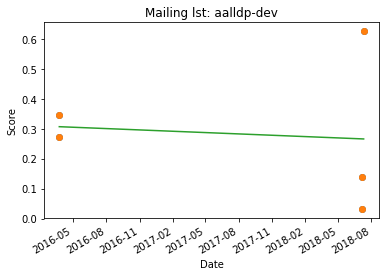

(2,)
(2,)


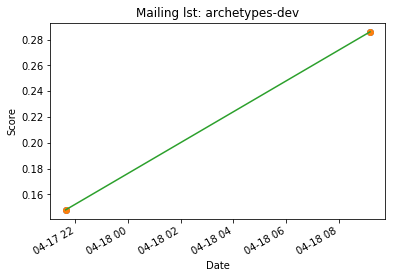

In [12]:
grouped = combine.groupby('mailing_list').groups
dates = []
values = []
mail_list = None
j = 0
for group in grouped:
    dates = (combine.loc[combine['mailing_list'] == group]['date']).tolist()
    values = (combine.loc[combine['mailing_list'] == group]['score']).unique().tolist()
    x = np.array(dates)
    dates = np.unique(x)
    #print(dates)
    dates1 = [x.to_pydatetime() for x in dates]
    fin_dates = mdates.date2num(dates1)
    fin_values = np.asarray(values)
    print(fin_dates.shape)
    print(fin_values.shape)
    plot.plot_date(fin_dates, fin_values)
    #plot.plot(fin_dates,fin_values)
    plot.gcf().autofmt_xdate()
    plot.title("Mailing lst: "+ group)
    plot.ylabel('Score')
    plot.xlabel('Date')
    #print(fin_dates)
    slope, intercept, r_value, p_value, std_err = stats.linregress(fin_dates,fin_values)
    line = slope*fin_dates+intercept
    plot.plot(fin_dates,fin_values,'o', fin_dates, line)
    #plot.savefig('foo' + str(x) + '.png')
    #x+=1
    plot.show()